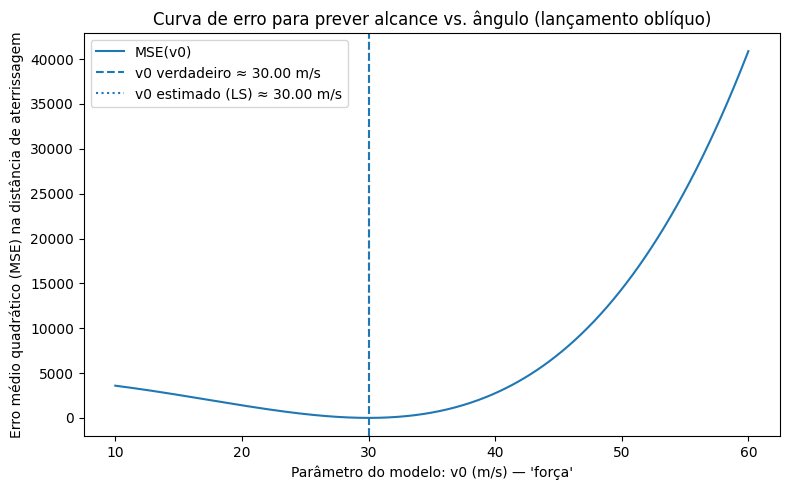

v0 verdadeiro: 30.0000 m/s
v0 estimado por mínimos quadrados: 30.0006 m/s


In [ ]:
# Simulate a "Gorillas"-style projectile learning problem and plot the training loss (error) curve
# Setup:
# - Input x_i: launch angle theta_i (in degrees)
# - Target y_i: landing distance R_i (range) for each theta_i
# - Model parameter to learn: launch speed v0 (here treated like "force")
#
# Physics (lançamento oblíquo, no ar arrasto): R(theta) = (v0^2 / g) * sin(2*theta)
#
# We'll synthesize a dataset using a true v0, add a bit of noise, then compute the MSE as a function
# of a candidate v0. This is the "error curve" the learner would minimize.

import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)

g = 9.81  # gravity (m/s^2)
v0_true = 30.0  # "true" launch speed (our hidden "force")
thetas_deg = np.linspace(5, 85, 25)  # a sweep of angles, avoiding 0 and 90
thetas_rad = np.deg2rad(thetas_deg)

# Ground-truth ranges with a touch of noise (to mimic imperfect measurements)
R_clean = (v0_true**2 / g) * np.sin(2 * thetas_rad)
noise = rng.normal(0, 2.0, size=thetas_deg.shape)  # meters of noise
R_obs = R_clean + noise

# Define the loss (MSE across all angles) as a function of candidate v0
def mse_for_v0(v0):
    R_pred = (v0**2 / g) * np.sin(2 * thetas_rad)
    return np.mean((R_obs - R_pred) ** 2)

# Sweep a range of candidate v0 values
v0_grid = np.linspace(10, 60, 400)
mse_grid = np.array([mse_for_v0(v) for v in v0_grid])

# Because R(theta) is linear in v0^2, we can also compute the closed-form least-squares optimum:
# Let s_i = sin(2*theta_i), y_i = R_obs_i
# y_i ≈ (w/g) * s_i, where w = v0^2
# Min over w:  w* = g * (Σ s_i y_i) / (Σ s_i^2), then v0_hat = sqrt(max(w*, 0))
s = np.sin(2 * thetas_rad)
w_hat = g * np.sum(s * R_obs) / np.sum(s**2)
v0_hat = float(np.sqrt(max(w_hat, 0.0)))

# Plot the error curve
plt.figure(figsize=(8, 5))
plt.plot(v0_grid, mse_grid, label="MSE(v0)")
plt.axvline(v0_true, linestyle="--", label=f"v0 verdadeiro ≈ {v0_true:.2f} m/s")
plt.axvline(v0_hat, linestyle=":", label=f"v0 estimado (LS) ≈ {v0_hat:.2f} m/s")
plt.xlabel("Parâmetro do modelo: v0 (m/s) — 'força'")
plt.ylabel("Erro médio quadrático (MSE) na distância de aterrissagem")
plt.title("Curva de erro para prever alcance vs. ângulo (lançamento oblíquo)")
plt.legend()
plt.tight_layout()
plt.show()

# Also print the numerical results
print(f"v0 verdadeiro: {v0_true:.4f} m/s")
print(f"v0 estimado por mínimos quadrados: {v0_hat:.4f} m/s")


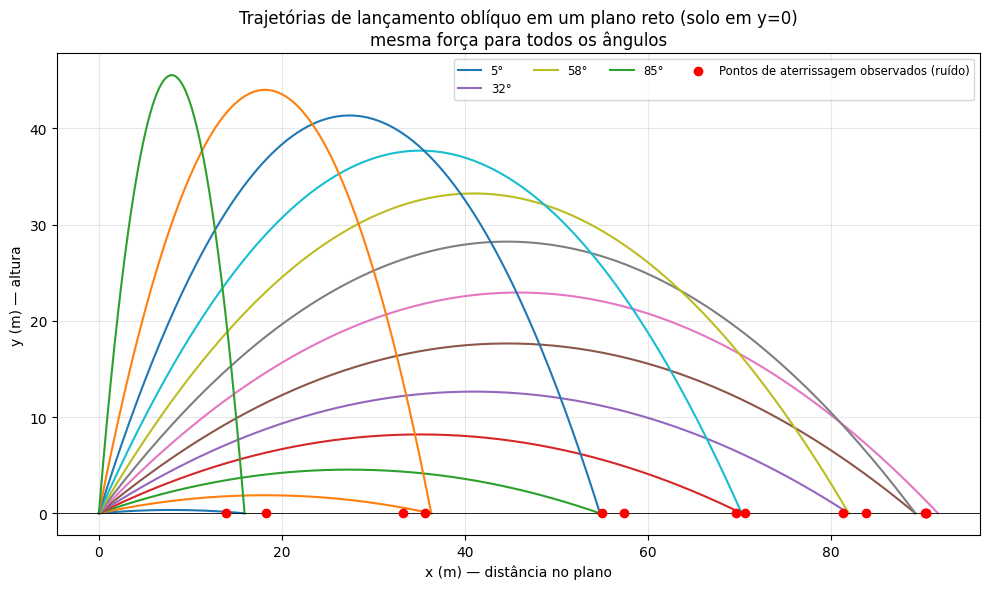

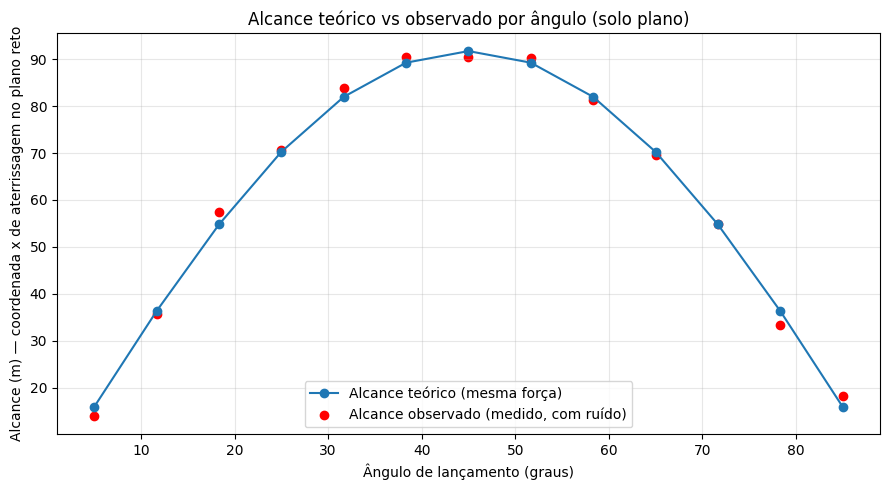

Resumo: lançamentos em plano reto (mesma força)


,angle_deg,time_of_flight_s,R_theoretical_m,R_observed_m,squared_error_m2
0,5.000000,0.533063,15.931025,13.952783,3.913444
1,11.666667,1.236805,36.337593,35.602020,0.541068
2,18.333333,1.923821,54.785192,57.361042,6.635006
3,25.000000,2.584821,70.279307,70.667256,0.150504
4,31.666667,3.210866,81.984646,83.825108,3.387300
5,38.333333,3.793489,89.270172,90.424379,1.332195
6,45.000000,4.324812,91.743119,90.470192,1.620344
7,51.666667,4.797649,89.270172,90.354076,1.174849
8,58.333333,5.205607,81.984646,81.351455,0.400931
9,65.000000,5.543167,70.279307,69.634528,0.415739



Observação: o 'plano reto' aqui significa solo em y=0 — todas as trajetórias terminam quando y retorna a 0.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# --------------------------
# Parâmetros
# --------------------------
g = 9.81
v0 = 30.0  # mesma força para todos os ângulos (m/s)
thetas_deg = np.linspace(5, 85, 13)  # menos pontos para visual ficar limpo
thetas_rad = np.deg2rad(thetas_deg)

# --------------------------
# Calcular tempo de voo e alcance ideal (sem ruído)
# --------------------------
T = 2 * v0 * np.sin(thetas_rad) / g
R = v0 * np.cos(thetas_rad) * T  # alcance teórico

# --------------------------
# Gerar medições observadas com ruído
# --------------------------
rng = np.random.default_rng(123)
R_obs = R + rng.normal(0, 2.0, size=R.shape)  # ruído nas medições

# --------------------------
# Gerar trajetórias (x(t), y(t)) para cada ângulo
# --------------------------
trajectories = []
for theta in thetas_rad:
    v_x = v0 * np.cos(theta)
    v_y = v0 * np.sin(theta)
    T_flight = 2 * v_y / g
    t = np.linspace(0, T_flight, 200)
    x = v_x * t
    y = v_y * t - 0.5 * g * t**2
    trajectories.append((x, y))

# --------------------------
# Plot 1: Trajetórias no plano com pontos de aterrissagem observados
# --------------------------
plt.figure(figsize=(10,6))
for i, (x, y) in enumerate(trajectories):
    plt.plot(x, y, lw=1.5, label=f'{thetas_deg[i]:.0f}°' if i in [0,4,8,12] else None)

plt.scatter(R_obs, np.zeros_like(R_obs), c='red', zorder=5, label='Pontos de aterrissagem observados (ruído)')
plt.axhline(0, color='k', lw=0.6)
plt.xlabel('x (m) — distância no plano')
plt.ylabel('y (m) — altura')
plt.title('Trajetórias de lançamento oblíquo em um plano reto (solo em y=0)\nmesma força para todos os ângulos')
plt.legend(ncol=4, fontsize='small', loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------
# Plot 2: Alcance teórico vs observado por ângulo
# --------------------------
plt.figure(figsize=(9,5))
plt.plot(thetas_deg, R, '-o', label='Alcance teórico (mesma força)')
plt.scatter(thetas_deg, R_obs, c='red', label='Alcance observado (medido, com ruído)')
plt.xlabel('Ângulo de lançamento (graus)')
plt.ylabel('Alcance (m) — coordenada x de aterrissagem no plano reto')
plt.title('Alcance teórico vs observado por ângulo (solo plano)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------
# Tabela resumida
# --------------------------
df = pd.DataFrame({
    'angle_deg': thetas_deg,
    'time_of_flight_s': T,
    'R_theoretical_m': R,
    'R_observed_m': R_obs,
    'squared_error_m2': (R_obs - R)**2
})

print("Resumo: lançamentos em plano reto (mesma força)")
display(df)

print("\nObservação: o 'plano reto' aqui significa solo em y=0 — todas as trajetórias terminam quando y retorna a 0.")


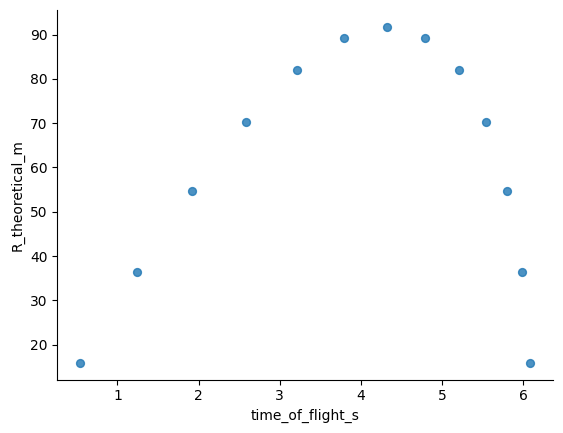

In [ ]:
# @title time_of_flight_s vs R_theoretical_m

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='time_of_flight_s', y='R_theoretical_m', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

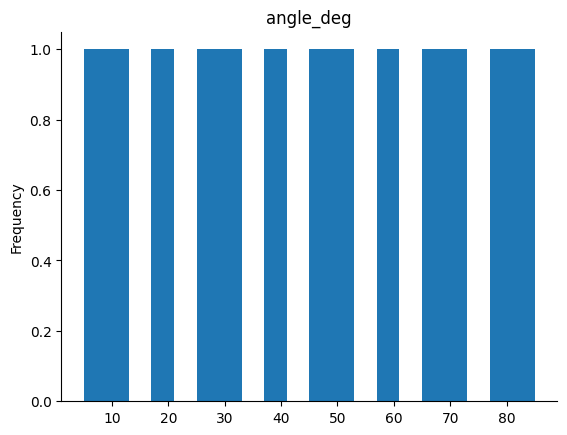

In [ ]:
# @title angle_deg

from matplotlib import pyplot as plt
df['angle_deg'].plot(kind='hist', bins=20, title='angle_deg')
plt.gca().spines[['top', 'right',]].set_visible(False)